In [1]:
%matplotlib inline
%pdb on
%run _547

Automatic pdb calling has been turned ON


# System model
Consider the simple pendulum model (see [1])
$$m\ddot{a} = -\frac{mg}{l} \sin(a) + \tau$$
where $a$ is pendulum angle, $l$ is rod length, $m$ is pendulum mass, $g$ is force due to gravity, and $\tau$ is an input torque arising from a motor attached to the rod at its pivot point.

If we measure or observe the pendulum angle (e.g. with an encoder on the pivot motor), then the ODE control system model is
$$\dot{x} = f(x,u),\ y = h(x)$$
where $x = (a,\dot{a})\in\mathbb{R}^2$, $u = \tau\in\mathbb{R}$, $f : \mathbb{R}^2 \times \mathbb{R} \rightarrow \mathbb{R}^2$ is defined by 
$$f((a,\dot{a}),u) = (\dot{a},\ddot{a}) = (\dot{a}, -\frac{g}{l} \sin(a) + \frac{1}{m}u),$$ 
and $h : \mathbb{R}^2 \rightarrow \mathbb{R}$ is defined by 
$$h(a,\dot{a}) = a.$$

    [1]: https://en.wikipedia.org/wiki/Pendulum_(mathematics)

# Simulation
To simulate the pendulum, we first implement Python versions of the ODE control system model; it'll be computationally expedient if both $f$ and $h$ accept $t$, $x$, and $u$ as arguments even though mathematically they may not depend on all three:

In [2]:
g,l,m = 9.81,.5,1. # m/sec^2, m, kg

def f(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([da,-(g/l)*np.sin(a) + (1/m)*u])

def h(t,x,u):
    a,da = x # angle (rad), velocity (rad/sec)
    return a # output only the angle

Note that $x_0 = (0,0)$ (i.e. zero angle and zero velocity) is an equilibrium:

In [3]:
x0 = [0,0]
print 'x0 =',x0,'\nf(x0) =',f(0.,x0,0)

x0 = [0, 0] 
f(x0) = [ 0.  0.]


Now we can simulate and plot the result; recall that, for small angles, the period of the pendulum swing is (approximately) $2\pi\sqrt{l/g}$:

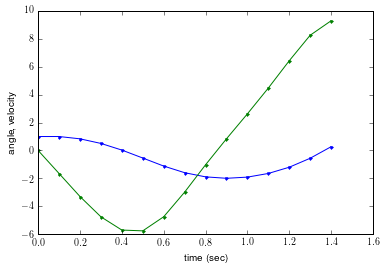

In [5]:
dt = 1e-1 # coarse timestep
t1 = 2*np.pi*np.sqrt(l/g) # approximately one period
x1 = [1.,0.] # "interesting" initial condition

u1 = lambda t : 0 # zero input function
# lambda is a shorthand way to define a function; equivalently:
def u1(t):
    return 0.

sim = forward_euler
t_,x_ = sim(f,t1,x1,dt=dt,ut=u1)
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. angle and velocity) at time t_[j]

plt.plot(t_,x_,'.-')
plt.xlabel('time (sec)')
plt.ylabel('angle, velocity')

Clearly the timestep is too large -- forward Euler injected lots of energy over one cycle -- so let's simulate with progressively smaller timesteps:

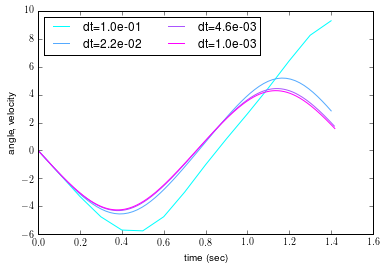

In [6]:
plt.figure()
plt.xlabel('time (sec)')
plt.ylabel('angle, velocity')

num = 4
dts = np.logspace(-3,-1,num=num,base=10.)[::-1]
cols = mpl.cm.cool(np.linspace(0.,1.,num=num))

for dt,col in zip(dts,cols):
  t_,x_ = sim(f,t1,x1,dt=dt,ut=u1)
  plt.plot(t_,x_[:,1],'-',color=col,label=r'dt=%0.1e'%dt)
    
plt.legend(ncol=2,loc='upper left')

Now let's apply some classical Proportional-Derivative (PD) feedback control:  $u(x) = -k_p a - k_d \dot{a}$.

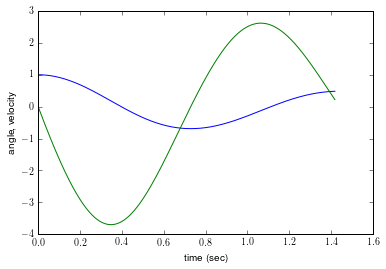

In [7]:
dt = 1e-3 
t1 = 1 * 2*np.pi*np.sqrt(l/g) 
x1 = [1.,0.] # "interesting" initial condition


kp,kd = 1.,1.
u1 = lambda t,x : -kp*x[0] - kd*x[1] # PD controller

t_,x_ = sim(f,t1,x1,dt=dt,utx=u1)
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. angle and velocity) at time t_[j]

plt.plot(t_,x_,'-')
plt.xlabel('time (sec)')
plt.ylabel('angle, velocity')

If we're given the derivative of the vector field function with respect to state, then we can approximate the linearization along a simulation trajectory.  Let's start with $D_x f$, the (Jacobian) derivative of the vector field $f$ with respect to the state $x = (a,\dot{a})$:
$$D_x f(x,u) = \left[ \begin{array}{cc} 0 & 1 \\ -\frac{g}{l}\cos(a) & 0 \end{array} \right]$$

In [8]:
def Dxf(x):
    a,da = x # angle (rad), velocity (rad/sec)
    return np.array([[0.,1.],[-(g/l)*np.cos(a),0.]])

Let's verify this is the derivative using finite-central-differences; we already wrote a function that applies to general $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
$$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
So we'll check that we get (approximately) the same result with the two methods (repeatedly press "Ctrl + Enter" to check at new random state):

In [9]:
x = np.random.randn(2)
print Dxf(x)
print D(lambda x : f(0.,x,0.), x, d=1e-6)

[[  0.           1.        ]
 [-19.27344925   0.        ]]
[[  0.           1.        ]
 [-19.27344925   0.        ]]


Note that finite-central-differences is sensitive to the "displacement" parameter:

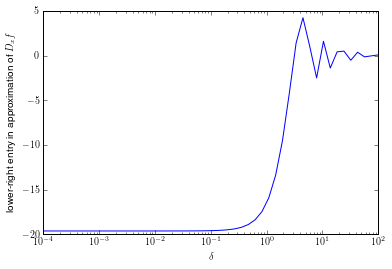

In [10]:
d = np.logspace(-4,2)
Dd = np.asarray([D(lambda x : f(0.,x,0.), x0, d=dd) for dd in d])
Dd.shape = (len(d),4)
plt.plot(d,Dd[:,2])
plt.xscale('log')
plt.xlabel('$\\delta$')
plt.ylabel('lower-right entry in approximation of $D_x f$')

Now to linearize along a trajectory, we need to define an auxiliary linear time-varying ODE:
$$\dot{\Phi}(s,0) = A(s) \Phi(s,0),\ \Phi(0,0) = I,\ A(s) = D_x f(s,x(s),u(s)).$$

In [11]:
def F(s,X,u): # assumes 0 <= s <= t
    j = np.int(s/dt)
    As = Dxf(x_[j]) # note: we're evaluating Dxf along the simulation x_
    return np.dot(As,X)

Then we can apply the same simulation algorithm to this (linear time-varying) ODE (i.e. the simulation algorithm doesn't need to know the system is LTV):

In [13]:
dt = 1e-1

u1 = lambda t : 0 # zero input function

t_,x_ = sim(f,t1,x1,dt=dt,ut=u1)

X1 = np.identity(2)
T_,X_ = sim(F,t1,X1,dt=dt,ut=u1)

For convenience, we defined a simulation function $\psi:\mathbb{N}\times\mathbb{R}^2\times U^\mathbb{R}\rightarrow \mathbb{R}^2$ that approximates the flow $\phi:\mathbb{R}\times\mathbb{R}^2\times U^\mathbb{R}\rightarrow \mathbb{R}^2$.  If we haven't made a mistake, then $D_x\phi(t,x) \approx D_x\psi(t,x) \approx X(t)$:

In [14]:
print np.round(X_[-1],2)
print np.round(D(lambda x : psi(f,t1,x,ut=u1,dt=dt), x1, d=1e-6),2)

[[-4.69 -1.3 ]
 [-1.57 -1.  ]]
[[-5.71 -0.84]
 [ 2.13 -0.11]]
